In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from utils import *
from cmdstanpy import CmdStanModel, set_cmdstan_path
import os
import arviz as az
sns.set_theme()

GEOLOCATION="unil"

GT_POINTS_CSV = f'datasets/raw/{GEOLOCATION}/gt_points.csv'
MEASUREMENTS_CSV = f'datasets/raw/{GEOLOCATION}/measurements.csv'
CMDSTAN_PATH = "/home/klemen/micromamba/envs/gps/bin/cmdstan"
STAN_MODEL_PATH = 'newmodel.stan'

measurements_df = pd.read_csv(MEASUREMENTS_CSV, parse_dates=["datetime"])
gt_points_df = pd.read_csv(GT_POINTS_CSV)
gt_points_df["plot_label"] = gt_points_df["name"] + " (GT)"
measurements_df["plot_label"] = measurements_df["measured_from"] + " (measured)"
measurements_df = remove_consecutive_duplicates(measurements_df)
proposal_names = gt_points_df["name"].tolist()
proposal_names.remove("E")
proposal_names

# TODO: consider precise

/home/klemen/micromamba/envs/gps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'Number of measurements per proposal (before consecutive deduplication):'


measured_from
P1    367
P2    332
dtype: int64

Number of measurements per proposal (after consecutive deduplication):
measured_from
P1    149
P2     51
dtype: int64


['P1', 'P2']

<Axes: xlabel='lng', ylabel='lat'>

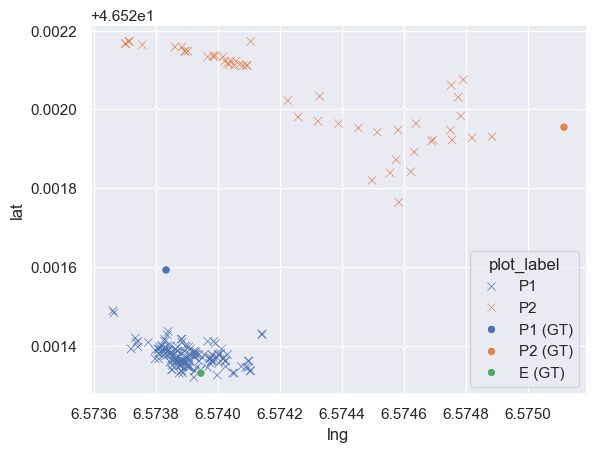

In [2]:
# visualize

fig, ax = plt.subplots()
sns.scatterplot(data=measurements_df, x='lng', y='lat', hue='measured_from', ax=ax, marker='x')
gt_points_df["plot_label"] = gt_points_df["name"] + " (GT)"
sns.scatterplot(data=gt_points_df, x='lng', y='lat', hue='plot_label', ax=ax)

In [3]:
gt_points_df

,name,lat,lng,plot_label
0,P1,46.521592,6.573832,P1 (GT)
1,P2,46.521955,6.575116,P2 (GT)
2,E,46.521331,6.573944,E (GT)


In [4]:
measurements_df

,measured_from,datetime,lat,lng,precise,plot_label
0,P1,2022-06-22 09:53:19,46.521344,6.573931,on,P1 (measured)
1,P1,2022-06-22 09:56:35,46.521408,6.573775,on,P1 (measured)
2,P1,2022-06-22 09:57:36,46.521381,6.573844,on,P1 (measured)
3,P1,2022-06-22 09:58:06,46.521361,6.573889,on,P1 (measured)
4,P1,2022-06-22 09:59:38,46.521386,6.573825,on,P1 (measured)
...,...,...,...,...,...,...
195,P2,2022-06-22 15:43:23,46.521892,6.574633,on,P2 (measured)
196,P2,2022-06-22 16:01:07,46.521919,6.574689,on,P2 (measured)
197,P2,2022-06-22 16:27:47,46.521922,6.574756,on,P2 (measured)
198,P2,2022-06-22 16:34:41,46.521928,6.574819,on,P2 (measured)


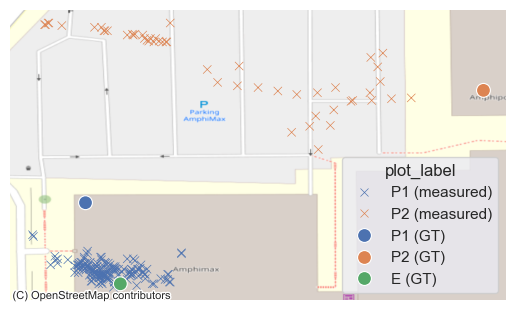

In [5]:
ax = raster_evidence_geomap(gt_points_df, measurements_df)

In [6]:
def transform(measurements_df, gt_points_df, proposal_col="measured_from"):
    # add dist, angle and angle_deg columns to measurements_df for each proposal
    measurements_df["dist"] = None
    measurements_df["angle_rad"] = None
    measurements_df["angle_deg"] = None
    # iterate over measurements and compute for each
    for i, row in measurements_df.iterrows():
        # get the proposal lat, lng
        proposal_name = row[proposal_col]
        proposal_lat_lng = gt_points_df[gt_points_df["name"] == proposal_name][["lat", "lng"]].values[0]
        dist, angle, angle_deg = lat_lng2dist_ang(proposal_lat_lng, [row["lat"], row["lng"]])
        measurements_df.at[i, "dist"] = dist
        measurements_df.at[i, "angle_rad"] = angle
        measurements_df.at[i, "angle_deg"] = angle_deg
    return measurements_df

P1_lat, P1_lng = gt_points_df[gt_points_df['name'] == 'P1'][['lat', 'lng']].values[0].tolist()
P2_lat, P2_lng = gt_points_df[gt_points_df['name'] == 'P2'][['lat', 'lng']].values[0].tolist()
E_lat, E_lng = gt_points_df[gt_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist()
E_P1_dist, E_P1_angle, E_P1_angle_deg = lat_lng2dist_ang([P1_lat, P1_lng], [E_lat, E_lng])
E_P2_dist, E_P2_angle, E_P2_angle_deg = lat_lng2dist_ang([P2_lat, P2_lng], [E_lat, E_lng])

print(f"P1: {P1_lat}, {P1_lng}")
print(f"P2: {P2_lat}, {P2_lng}")
print(f"E: {E_lat}, {E_lng}")
print(f"E using P1 as the center: dist={E_P1_dist}, angle={E_P1_angle}, angle_deg={E_P1_angle_deg}")
print(f"E using P2 as the center: dist={E_P2_dist}, angle={E_P2_angle}, angle_deg={E_P2_angle_deg}")


P1: 46.521592273, 6.573832039
P2: 46.521954786, 6.575116326
E: 46.521330555, 6.573944444
E using P1 as the center: dist=30.344572744546294, angle=2.8533795973322875, angle_deg=163.48660827587835
E using P2 as the center: dist=113.5817863518005, angle=4.055162326777971, angle_deg=232.34368656482852


In [7]:
measurements_df = transform(measurements_df, gt_points_df)
measurements_df

,measured_from,datetime,lat,lng,precise,plot_label,dist,angle_rad,angle_deg
0,P1,2022-06-22 09:53:19,46.521344,6.573931,on,P1 (measured),28.56732,2.873785,164.655746
1,P1,2022-06-22 09:56:35,46.521408,6.573775,on,P1 (measured),20.91019,3.352463,192.082006
2,P1,2022-06-22 09:57:36,46.521381,6.573844,on,P1 (measured),23.554072,3.101168,177.68385
3,P1,2022-06-22 09:58:06,46.521361,6.573889,on,P1 (measured),26.063941,2.973435,170.365252
4,P1,2022-06-22 09:59:38,46.521386,6.573825,on,P1 (measured),22.923629,3.165157,181.350112
...,...,...,...,...,...,...,...,...,...
195,P2,2022-06-22 15:43:23,46.521892,6.574633,on,P2 (measured),37.719201,4.525284,259.279701
196,P2,2022-06-22 16:01:07,46.521919,6.574689,on,P2 (measured),33.032434,4.593177,263.169673
197,P2,2022-06-22 16:27:47,46.521922,6.574756,on,P2 (measured),27.918201,4.582366,262.550258
198,P2,2022-06-22 16:34:41,46.521928,6.574819,on,P2 (measured),22.977217,4.581353,262.492195


ValueError: Unable to parse string "P1 (measured)" at position 0

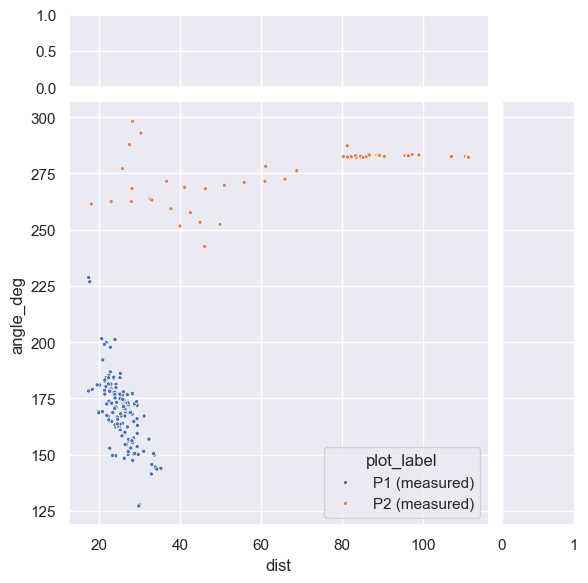

In [54]:
#! P1(measured) and P2(measured) are measurements that are transformed to dist and angle WITH RESPECT TO THEIR GROUND TRUTH (P1 or P2)
g = sns.jointplot(
        data=measurements_df,
        x="dist",
        y="angle_deg",
        hue="plot_label",
        kind="scatter",
        marginal_ticks=True,
        joint_kws={"marker": "."},
        # marginal_kws={"multiple": "fill"}, # nah we dont see dist
        marginal_kws={"hue_norm": (0, 1)}, #! TODO investigate here: https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot
        # alpha=0.5
    )

# lower bound for distance is 0
g.ax_joint.set_xlim(left=0)

#! TODO: HERE WE HAVE TO COMPUTE MARGINALS SEPARATELY AS WE WANT TO HAVE THEM ON THE SAME Y FOR ALL HUES AND WE WANT TO DRAW LINES FOR E W.R.T. P1 AND P2 IN THEM

for proposal_name in proposal_names:
    proposal_lat_lng = gt_points_df[gt_points_df["name"] == proposal_name][["lat", "lng"]].values[0]
    dist, angle, angle_deg = lat_lng2dist_ang(proposal_lat_lng, [E_lat, E_lng])
    g.ax_joint.plot(dist, angle_deg, 'X', label=f"E w.r.t. {proposal_name}", markersize=10)
g.ax_joint.legend()

array([<PolarAxes: title={'center': 'P1'}>,
       <PolarAxes: title={'center': 'P2'}>], dtype=object)

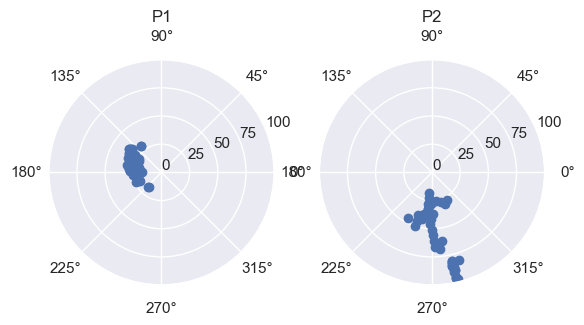

In [9]:
def visualize_polar(measurements_df, gt_points_df):
    fig, ax = plt.subplots(1, gt_points_df.shape[0] - 1, subplot_kw=dict(polar=True))
    # meters and degrees
    for i, row in gt_points_df.iterrows():
        if row["name"] == "E":
            continue
        proposal_name = row["name"]
        proposal_data = measurements_df[measurements_df["measured_from"] == proposal_name]
        ax[i].scatter(proposal_data["angle_rad"], proposal_data["dist"], label=proposal_name)
        ax[i].set_title(proposal_name)
        ax[i].set_ylim(0, 100)
        ax[i].set_yticks([0, 25, 50, 75, 100])
                          
    return ax

visualize_polar(measurements_df, gt_points_df)